# Distributed (multi-function) pipeline example

This example demonstrates how to run a pipeline that consists of multiple serverless functions (connected using streams).

In the pipeline example the request contains the a URL of a file. It loads the content of the file and breaks it into paragraphs (using the FlatMap class), and pushes the results to a queue/stream. The second function picks up the paragraphs and runs the NLP flow to extract the entities and push the results to the output stream.

**Setting the stream URLs for the internal queue, the final output and error/exceptions stream:**

In [1]:
streams_prefix = "v3io:///users/admin/"
internal_stream = streams_prefix + "in-stream"
out_stream = streams_prefix + "out-stream"
err_stream = streams_prefix + "err-stream"

Alternatively, using Kafka:

In [ ]:
kafka_prefix = f"kafka://{broker}/"
internal_topic = kafka_prefix + "in-topic"
out_topic = kafka_prefix + "out-topic"
err_topic = kafka_prefix + "err-topic"

In either case, continue with:

In [2]:
# set up the environment
import mlrun
mlrun.set_environment(project="pipe")

> 2021-05-03 14:28:39,987 [warning] Failed resolving version info. Ignoring and using defaults
> 2021-05-03 14:28:43,801 [warning] Unable to parse server or client version. Assuming compatible: {'server_version': '0.6.3-rc4', 'client_version': 'unstable'}


('pipe', '/v3io/projects/{{run.project}}/artifacts')

In [3]:
# uncomment to install spacy requirements locally
# !pip install spacy
# !python -m spacy download en_core_web_sm

**In this example**
- [Create the pipeline](#create-the-pipeline)
- [Test the pipeline locally](#test-the-pipeline-locally)
- [Deploy to the cluster](#deploy-to-the-cluster)

## Create the pipeline

The pipeline consists of two functions: data-prep and NLP. Each one has different package dependencies.

**Create a file with data-prep graph steps:**

In [4]:
%%writefile data_prep.py
import mlrun
import json

# load struct from a json file (event points to the url)
def load_url(event):
    url = event["url"]
    data = mlrun.get_object(url).decode("utf-8")
    return {"url": url, "doc": json.loads(data)}

def to_paragraphs(event):
    paragraphs = []
    url = event["url"]
    for i, paragraph in enumerate(event["doc"]):
        paragraphs.append(
            {"url": url, "paragraph_id": i, "paragraph": paragraph}
        )
    return paragraphs

Overwriting data_prep.py


**Create a file with NLP graph steps (use spacy):**

In [5]:
%%writefile nlp.py
import json
import spacy

def myprint(x):
    print(x)
    return x

class ApplyNLP:
    def __init__(self, context=None, spacy_dict="en_core_web_sm"):

        self.nlp = spacy.load(spacy_dict)

    def do(self, paragraph: dict):
        tokenized_paragraphs = []
        if isinstance(paragraph, (str, bytes)):
            paragraph = json.loads(paragraph)
        tokenized = {
            "url": paragraph["url"],
            "paragraph_id": paragraph["paragraph_id"],
            "tokens": self.nlp(paragraph["paragraph"]),
        }
        tokenized_paragraphs.append(tokenized)

        return tokenized_paragraphs

def extract_entities(tokens):
    paragraph_entities = []
    for token in tokens:
        entities = token["tokens"].ents
        for entity in entities:
            paragraph_entities.append(
                {
                    "url": token["url"],
                    "paragraph_id": token["paragraph_id"],
                    "entity": entity.ents,
                }
            )
    return paragraph_entities

def enrich_entities(entities):
    enriched_entities = []
    for entity in entities:
        enriched_entities.append(
            {
                "url": entity["url"],
                "paragraph_id": entity["paragraph_id"],
                "entity_text": entity["entity"][0].text,
                "entity_start_char": entity["entity"][0].start_char,
                "entity_end_char": entity["entity"][0].end_char,
                "entity_label": entity["entity"][0].label_,
            }
        )
    return enriched_entities

Overwriting nlp.py


**Build and show the graph:**

Create the master function ("multi-func") with the `data_prep.py` source and an async graph topology. 
Add a pipeline of steps made of custom python handlers, classes and built-in classes (like `storey.FlatMap`).

The pipeline runs across two functions which are connected by a queue/stream (q1). Use the `function=` to specify which function runs the specified step.
End the flow with writing to the output stream.

In [6]:
# define a new real-time serving function (from code) with an async graph
fn = mlrun.code_to_function("multi-func", filename="./data_prep.py", kind="serving", image='mlrun/mlrun')
graph = fn.set_topology("flow", engine="async")

# define the graph steps (DAG)
graph.to(name="load_url", handler="load_url")\
     .to(name="to_paragraphs", handler="to_paragraphs")\
     .to("storey.FlatMap", "flatten_paragraphs", _fn="(event)")\
     .to(">>", "q1", path=internal_stream)\
     .to(name="nlp", class_name="ApplyNLP", function="enrich")\
     .to(name="extract_entities", handler="extract_entities", function="enrich")\
     .to(name="enrich_entities", handler="enrich_entities", function="enrich")\
     .to("storey.FlatMap", "flatten_entities", _fn="(event)", function="enrich")\
     .to(name="printer", handler="myprint", function="enrich")\
     .to(">>", "output_stream", path=out_stream)

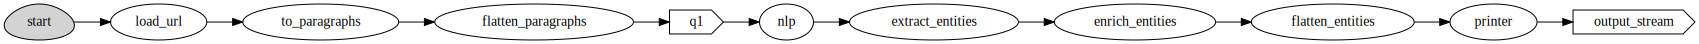

In [7]:
# specify the "enrich" child function, add extra package requirements
child = fn.add_child_function('enrich', './nlp.py', 'mlrun/mlrun')
child.spec.build.commands = ["python -m pip install spacy",
                             "python -m spacy download en_core_web_sm"]
graph.plot(rankdir='LR')

## Test the pipeline locally

**Create an input file:**

In [8]:
%%writefile in.json
["Born and raised in Queens, New York City, Trump attended Fordham University for two years and received a bachelor's degree in economics from the Wharton School of the University of Pennsylvania. He became president of his father Fred Trump's real estate business in 1971, renamed it The Trump Organization, and expanded its operations to building or renovating skyscrapers, hotels, casinos, and golf courses. Trump later started various side ventures, mostly by licensing his name. Trump and his businesses have been involved in more than 4,000 state and federal legal actions, including six bankruptcies. He owned the Miss Universe brand of beauty pageants from 1996 to 2015, and produced and hosted the reality television series The Apprentice from 2004 to 2015.", 
 "Trump's political positions have been described as populist, protectionist, isolationist, and nationalist. He entered the 2016 presidential race as a Republican and was elected in a surprise electoral college victory over Democratic nominee Hillary Clinton while losing the popular vote.[a] He became the oldest first-term U.S. president[b] and the first without prior military or government service. His election and policies have sparked numerous protests. Trump has made many false or misleading statements during his campaign and presidency. The statements have been documented by fact-checkers, and the media have widely described the phenomenon as unprecedented in American politics. Many of his comments and actions have been characterized as racially charged or racist."]

Overwriting in.json


**Create a mock server (simulator) and test:**

In [9]:
# tuggle verbosity if needed
fn.verbose = False

In [10]:
to
# create a mock server (simulator), specify to simulate all the functions in the pipeline ("*")
server = fn.to_mock_server(current_function="*")

In [11]:
# push a sample request into the pipeline and see the results print out (by the printer step)
resp = server.test(body={"url": "in.json"})

{'url': 'in.json', 'paragraph_id': 0, 'entity_text': 'Queens', 'entity_start_char': 19, 'entity_end_char': 25, 'entity_label': 'GPE'}
{'url': 'in.json', 'paragraph_id': 0, 'entity_text': 'New York City', 'entity_start_char': 27, 'entity_end_char': 40, 'entity_label': 'GPE'}
{'url': 'in.json', 'paragraph_id': 0, 'entity_text': 'Trump', 'entity_start_char': 42, 'entity_end_char': 47, 'entity_label': 'ORG'}
{'url': 'in.json', 'paragraph_id': 0, 'entity_text': 'Fordham University', 'entity_start_char': 57, 'entity_end_char': 75, 'entity_label': 'ORG'}
{'url': 'in.json', 'paragraph_id': 0, 'entity_text': 'two years', 'entity_start_char': 80, 'entity_end_char': 89, 'entity_label': 'DATE'}
{'url': 'in.json', 'paragraph_id': 0, 'entity_text': 'the Wharton School of the University of Pennsylvania', 'entity_start_char': 141, 'entity_end_char': 193, 'entity_label': 'ORG'}
{'url': 'in.json', 'paragraph_id': 0, 'entity_text': 'Fred Trump', 'entity_start_char': 229, 'entity_end_char': 239, 'entity_l

In [ ]:
server.wait_for_completion()

## Deploy to the cluster

In [14]:
# add credentials to the data/streams
fn.apply(mlrun.platforms.v3io_cred())
child.apply(mlrun.platforms.v3io_cred())

# specify the error stream (to store exceptions from the functions)
fn.spec.error_stream = err_stream

# deploy as a set of serverless functions
fn.deploy()

> 2021-05-03 14:33:55,400 [info] deploy child function enrich ...
> 2021-05-03 14:33:55,427 [info] Starting remote function deploy
2021-05-03 14:33:55  (info) Deploying function
2021-05-03 14:33:55  (info) Building
2021-05-03 14:33:55  (info) Staging files and preparing base images
2021-05-03 14:33:55  (info) Building processor image
2021-05-03 14:34:02  (info) Build complete
2021-05-03 14:34:08  (info) Function deploy complete
> 2021-05-03 14:34:09,232 [info] function deployed, address=default-tenant.app.yh30.iguazio-c0.com:32356
> 2021-05-03 14:34:09,233 [info] deploy root function multi-func ...
> 2021-05-03 14:34:09,234 [info] Starting remote function deploy
2021-05-03 14:34:09  (info) Deploying function
2021-05-03 14:34:09  (info) Building
2021-05-03 14:34:09  (info) Staging files and preparing base images
2021-05-03 14:34:09  (info) Building processor image
2021-05-03 14:34:16  (info) Build complete
2021-05-03 14:34:22  (info) Function deploy complete
> 2021-05-03 14:34:22,891 [i

'http://default-tenant.app.yh30.iguazio-c0.com:32046'

**Listen on the output stream**

You can use the SDK or CLI to listen on the output stream. Listening should be done in a separate console/notebook. Run:

    mlrun watch-stream v3io:///users/admin/out-stream -j

or use the SDK:
```python
from mlrun.platforms import watch_stream
watch_stream("v3io:///users/admin/out-stream", is_json=True)
```

**Test the live function:**
```{Note}  The url must be a valid path to the input file.

In [22]:
fn.invoke('', body={"url": "v3io:///users/admin/pipe/in.json"})

{'id': '79354e45-a158-405f-811c-976e9cf4ab5e'}